# Due to memory constraints, the training data is converted into 6 `.npy` files (from 3 `.parquet` files) for easier access. 

### 

### This process can be checked in the `process.py` file. 
### Chunking is avoided to ensure that data is not reduced and utilize the maximum possible data provided.

In [1]:
import os
import cv2
import timm
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, Sampler
from torch.optim import Adam, SGD
from torchvision import transforms, models
from torchvision.models import resnet18  
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
gpus = torch.cuda.device_count()

if gpus <= 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPU')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPUs')


Using 1 GPU


In [4]:
MIX = False
if MIX:
    scaler = GradScaler()
    print('Mixed precision enabled')
else:
    print('Using full precision')


Using full precision


In [5]:
load1 = np.load('/kaggle/input/commontask2/train_1.npy',allow_pickle=True)
load2 = np.load('/kaggle/input/commontask2/train_3.npy',allow_pickle=True)

In [6]:
df1 = pd.DataFrame(data=load1)
df2 = pd.DataFrame(data=load2)
df = pd.concat([df1, df2], ignore_index=True)

In [7]:
df.columns = ['X_jets', 'pt', 'm0', 'y']

In [8]:
df.head()

,X_jets,pt,m0,y
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",102.314308,24.096939,1
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",110.484772,15.924516,1
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",144.097046,24.43207,0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",88.222,15.130034,1
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",134.768311,23.440683,1


In [ ]:
images = df['X_jets'].iloc[:3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
for i, image in enumerate(images):
    axes[i].imshow(image.transpose(1, 2, 0)) 
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

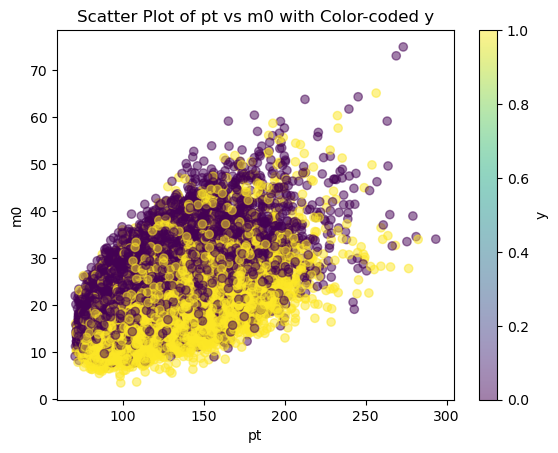

In [9]:
dataset= df
plt.scatter(dataset['pt'], dataset['m0'], c=dataset['y'], cmap='viridis', alpha=0.5)

plt.xlabel('pt')
plt.ylabel('m0')
plt.title('Scatter Plot of pt vs m0 with Color-coded y')
plt.colorbar(label='y')
plt.show()


In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify= df['y'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42,stratify=train_df['y'])

In [11]:
class CFG:
    model_name = 'vgg12'
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.001 
    num_epochs = 20
    random_state = 42
    decay_rate = 0.4

In [12]:
class Custom_Net(nn.Module):
    def __init__(self):
        super(Custom_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.pool3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return nn.Sigmoid()(out.squeeze())

In [40]:
model = Custom_Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)
criterion = nn.BCELoss().to(device)

In [14]:
X_jets_flat_train = np.stack(train_df['X_jets'].apply(np.concatenate).values)
X_train = torch.tensor(X_jets_flat_train, dtype=torch.float32).view(-1, 125,125, 3)
y_train = torch.tensor(train_df['y'], dtype=torch.int8)

X_jets_flat_train= np.stack(val_df['X_jets'].apply(np.concatenate).values)
X_val = torch.tensor(X_jets_flat_train, dtype=torch.float32).view(-1,125, 125, 3)

y_val = pd.to_numeric(val_df['y'])
y_val = y_val.astype(dtype='float32')
y_val = torch.tensor(y_val.values, dtype=torch.float32)

X_test = np.stack(test_df['X_jets'].apply(np.concatenate).values)
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 125,125, 3)

y_test = pd.to_numeric(test_df['y'])
y_test = y_test.astype(dtype='float32')
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)

In [41]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_roc_aucs = []
val_roc_aucs = []

best_val_accuracy = 0.0
best_model_state_dict = None

for epoch in range(CFG.num_epochs):
    model.train()
    train_running_loss = 0
    correct_train = 0
    total_train = 0
    y_true = []
    y_scores = []
    
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.num_epochs}", leave=False) as train_loader_with_progress:
        for inputs, labels in train_loader_with_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            inputs = inputs.permute(0, 3, 1, 2)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            predicted_train = torch.round(outputs)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)
            train_loader_with_progress.set_postfix(train_loss=loss.item())
            y_true += labels.cpu().detach().numpy().tolist()
            y_scores += outputs.cpu().detach().numpy().tolist()

    
            
    
    train_loss = train_running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    roc_auc_train = roc_auc_score(y_true, y_scores)
    train_roc_aucs.append(roc_auc_train)
    
    model.eval()
    val_running_loss = 0
    correct_val = 0
    total_val = 0
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_inputs = val_inputs.permute(0, 3, 1, 2)
            outputs = model(val_inputs)
            loss = criterion(outputs, val_labels.float())
            val_running_loss += loss.item()
            predicted_val = torch.round(outputs)
            correct_val += (predicted_val == val_labels).sum().item()
            total_val += val_labels.size(0)
            y_true += val_labels.cpu().numpy().tolist()
            y_scores += outputs.cpu().numpy().tolist()
    
    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    val_roc_auc = roc_auc_score(y_true, y_scores)
    val_roc_aucs.append(val_roc_auc)
    
    print(f"Epoch {epoch + 1}/{CFG.num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Train ROC-AUC: {roc_auc_train:.3f}, Val ROC-AUC: {val_roc_auc:.3f}")
    
    scheduler.step(val_roc_auc)
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state_dict = model.state_dict()
        torch.save(best_model_state_dict, "model_weights_Common_Task_2(1).pth")

print("Model saved successfully.")
print("Finished training")


Epoch 1/20, Train Loss: 0.8176, Train Acc: 66.69%, Val Loss: 0.6298, Val Acc: 68.24%, Train ROC-AUC: 0.712, Val ROC-AUC: 0.770


Epoch 2/20, Train Loss: 0.5931, Train Acc: 69.88%, Val Loss: 0.6261, Val Acc: 66.91%, Train ROC-AUC: 0.757, Val ROC-AUC: 0.774


Epoch 3/20, Train Loss: 0.5867, Train Acc: 70.49%, Val Loss: 0.6006, Val Acc: 69.58%, Train ROC-AUC: 0.765, Val ROC-AUC: 0.773


Epoch 4/20, Train Loss: 0.5790, Train Acc: 71.32%, Val Loss: 0.5942, Val Acc: 69.65%, Train ROC-AUC: 0.774, Val ROC-AUC: 0.773


Epoch 5/20, Train Loss: 0.5769, Train Acc: 71.27%, Val Loss: 0.6071, Val Acc: 70.48%, Train ROC-AUC: 0.774, Val ROC-AUC: 0.774
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


Epoch 6/20, Train Loss: 0.5618, Train Acc: 72.37%, Val Loss: 0.5969, Val Acc: 71.25%, Train ROC-AUC: 0.788, Val ROC-AUC: 0.776


Epoch 7/20, Train Loss: 0.5571, Train Acc: 72.76%, Val Loss: 0.6243, Val Acc: 70.27%, Train ROC-AUC: 0.792, Val ROC-AUC: 0.771


Epoch 8/20, Train Loss: 0.5550, Train Acc: 72.84%, Val Loss: 0.5931, Val Acc: 71.13%, Train ROC-AUC: 0.793, Val ROC-AUC: 0.774


Epoch 9/20, Train Loss: 0.5539, Train Acc: 72.95%, Val Loss: 0.6002, Val Acc: 70.84%, Train ROC-AUC: 0.794, Val ROC-AUC: 0.776
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


Epoch 10/20, Train Loss: 0.5487, Train Acc: 73.50%, Val Loss: 0.6076, Val Acc: 70.08%, Train ROC-AUC: 0.800, Val ROC-AUC: 0.773


Epoch 11/20, Train Loss: 0.5496, Train Acc: 73.38%, Val Loss: 0.5976, Val Acc: 71.30%, Train ROC-AUC: 0.799, Val ROC-AUC: 0.776


Epoch 12/20, Train Loss: 0.5477, Train Acc: 73.45%, Val Loss: 0.6061, Val Acc: 71.27%, Train ROC-AUC: 0.799, Val ROC-AUC: 0.775


Epoch 13/20, Train Loss: 0.5468, Train Acc: 73.52%, Val Loss: 0.5935, Val Acc: 70.60%, Train ROC-AUC: 0.800, Val ROC-AUC: 0.774
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


Epoch 14/20, Train Loss: 0.5471, Train Acc: 73.51%, Val Loss: 0.5981, Val Acc: 70.94%, Train ROC-AUC: 0.800, Val ROC-AUC: 0.774


Epoch 15/20, Train Loss: 0.5465, Train Acc: 73.49%, Val Loss: 0.5975, Val Acc: 71.06%, Train ROC-AUC: 0.801, Val ROC-AUC: 0.776


Epoch 16/20, Train Loss: 0.5477, Train Acc: 73.55%, Val Loss: 0.5970, Val Acc: 71.10%, Train ROC-AUC: 0.800, Val ROC-AUC: 0.776


Epoch 17/20, Train Loss: 0.5456, Train Acc: 73.59%, Val Loss: 0.5937, Val Acc: 70.79%, Train ROC-AUC: 0.801, Val ROC-AUC: 0.774
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.


Epoch 18/20, Train Loss: 0.5467, Train Acc: 73.57%, Val Loss: 0.5975, Val Acc: 71.27%, Train ROC-AUC: 0.801, Val ROC-AUC: 0.775


Epoch 19/20, Train Loss: 0.5466, Train Acc: 73.49%, Val Loss: 0.6010, Val Acc: 70.96%, Train ROC-AUC: 0.801, Val ROC-AUC: 0.775


Epoch 20/20, Train Loss: 0.5465, Train Acc: 73.58%, Val Loss: 0.5874, Val Acc: 71.30%, Train ROC-AUC: 0.801, Val ROC-AUC: 0.774
Model saved successfully.
Finished training


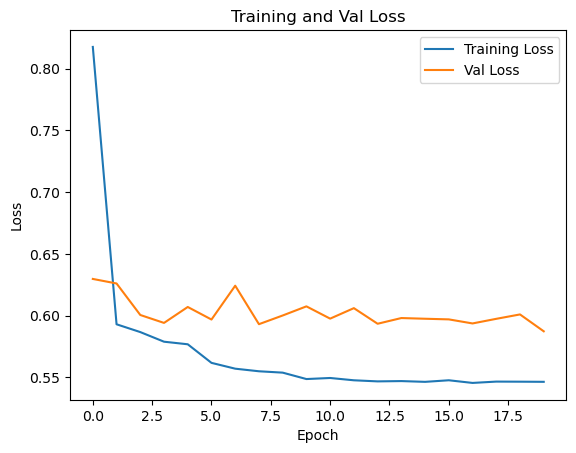

In [42]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Val Loss")
plt.legend()
plt.show()

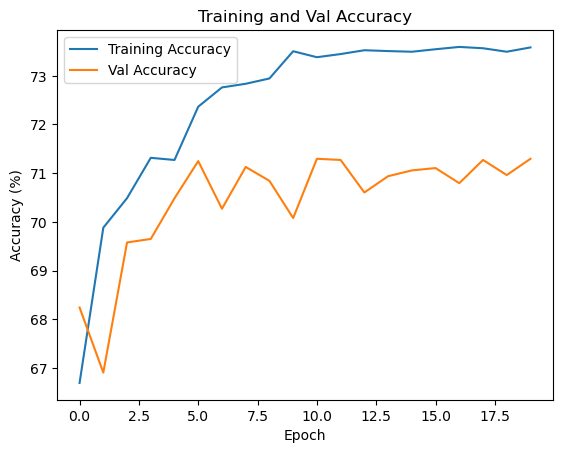

In [43]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Val Accuracy")
plt.legend()
plt.show()

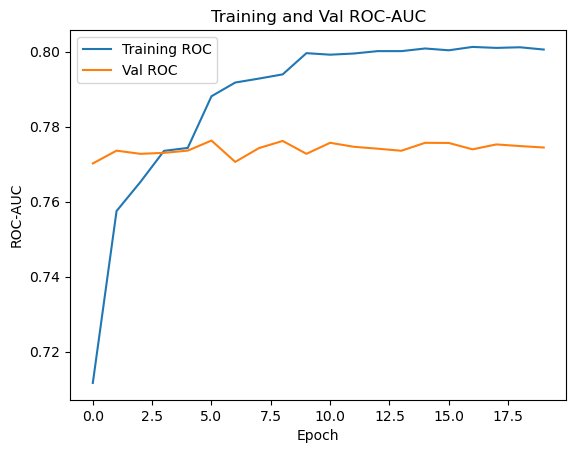

In [44]:
plt.plot(train_roc_aucs, label="Training ROC")
plt.plot(val_roc_aucs, label="Val ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training and Val ROC-AUC")
plt.legend()
plt.show()

In [46]:
correct_predictions_count = 0
all_preds = []
all_labels = []
y_true = []
y_scores = []

best_model = Custom_Net()
best_model.load_state_dict(torch.load("model_weights_Common_Task_2(1).pth"))
best_model.eval().to(device)

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = best_model(inputs)
        preds = (outputs >= 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        y_true += labels.cpu().numpy().tolist()
        y_scores += outputs.cpu().numpy().tolist()
        correct_predictions_count += torch.sum(preds == labels).item()

total_instances = len(all_labels)
accuracy = correct_predictions_count / total_instances
roc_auc = roc_auc_score(y_true, y_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

100%|██████████| 66/66 [00:01<00:00, 52.71it/s]

Test Accuracy: 0.7204
ROC-AUC Score: 0.7804


In [47]:
class CustomVGG12(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomVGG12, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 15 * 15, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096,1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()

In [53]:
model = CustomVGG12().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=CFG.decay_rate)

In [54]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_roc_aucs = []
val_roc_aucs = []
best_val_accuracy = 0.0
best_model_state_dict = None

for epoch in range(10):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_preds_list = []
    y_true = []
    y_scores = []

    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10} (Training)') as train_loader_with_progress:
        for inputs, labels in train_loader_with_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs.to(torch.float32)
            labels = labels.to(torch.float32)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.sigmoid(outputs)
            preds = (preds >= 0.5).float()
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
            train_preds_list.append(preds.detach().cpu().numpy())
            y_true += labels.cpu().detach().numpy().tolist()
            y_scores += outputs.cpu().detach().numpy().tolist()
            train_loader_with_progress.set_postfix(train_loss=train_loss)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_preds = np.concatenate(train_preds_list)
    train_auc_roc = roc_auc_score(y_true,y_scores)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    train_roc_aucs.append(train_auc_roc)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds_list = []
    y_true = []
    y_scores = []
    with tqdm(val_loader, desc=f'Epoch {epoch + 1}/{10} (Validation)') as val_loader_with_progress:
        for inputs, labels in val_loader_with_progress:
            inputs = inputs.permute(0, 3, 1, 2)
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model(inputs)
            val_outputs = val_outputs.to(torch.float32)
            labels = labels.to(torch.float32)
            if len(labels.size()) > 1:
                labels = labels.squeeze(dim=1)
            val_loss += criterion(val_outputs, labels).item()

            preds = torch.sigmoid(val_outputs)
            preds = (preds >= 0.5).float()
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_preds_list.append(preds.detach().cpu().numpy())
            y_true += labels.cpu().detach().numpy().tolist()
            y_scores += val_outputs.cpu().detach().numpy().tolist()
            val_loader_with_progress.set_postfix(val_loss=val_loss)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_preds = np.concatenate(val_preds_list)
    val_auc_roc = roc_auc_score(y_true, y_scores)
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    val_roc_aucs.append(val_auc_roc)
    scheduler.step()

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()
        
    print(f"Epoch {epoch + 1}/{10}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train AUC-ROC: {train_auc_roc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC-ROC: {val_auc_roc:.4f}")

torch.save(best_model_state_dict, "model_weights_Common_Task_2(2).pth")
print("Model saved successfully.")
print("Finished training")

Epoch 1/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.9]


Epoch 1/10, Train Loss: 0.6593, Train Accuracy: 0.6364, Train AUC-ROC: 0.6892, Val Loss: 0.6039, Val Accuracy: 0.6805, Val AUC-ROC: 0.7450


Epoch 2/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.5]


Epoch 2/10, Train Loss: 0.5917, Train Accuracy: 0.6996, Train AUC-ROC: 0.7583, Val Loss: 0.5906, Val Accuracy: 0.6922, Val AUC-ROC: 0.7621


Epoch 3/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.4]


Epoch 3/10, Train Loss: 0.5744, Train Accuracy: 0.7136, Train AUC-ROC: 0.7725, Val Loss: 0.5872, Val Accuracy: 0.6977, Val AUC-ROC: 0.7676


Epoch 4/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.1]


Epoch 4/10, Train Loss: 0.5670, Train Accuracy: 0.7198, Train AUC-ROC: 0.7789, Val Loss: 0.5800, Val Accuracy: 0.7072, Val AUC-ROC: 0.7704


Epoch 5/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.55it/s, val_loss=19.2]


Epoch 5/10, Train Loss: 0.5638, Train Accuracy: 0.7202, Train AUC-ROC: 0.7820, Val Loss: 0.5807, Val Accuracy: 0.7046, Val AUC-ROC: 0.7708


Epoch 6/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.1]


Epoch 6/10, Train Loss: 0.5624, Train Accuracy: 0.7212, Train AUC-ROC: 0.7832, Val Loss: 0.5788, Val Accuracy: 0.7082, Val AUC-ROC: 0.7714


Epoch 7/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s, val_loss=19.1]


Epoch 7/10, Train Loss: 0.5622, Train Accuracy: 0.7217, Train AUC-ROC: 0.7832, Val Loss: 0.5783, Val Accuracy: 0.7072, Val AUC-ROC: 0.7716


Epoch 8/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.55it/s, val_loss=19.1]


Epoch 8/10, Train Loss: 0.5626, Train Accuracy: 0.7210, Train AUC-ROC: 0.7838, Val Loss: 0.5783, Val Accuracy: 0.7082, Val AUC-ROC: 0.7717


Epoch 9/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s, val_loss=19.1]


Epoch 9/10, Train Loss: 0.5616, Train Accuracy: 0.7214, Train AUC-ROC: 0.7841, Val Loss: 0.5782, Val Accuracy: 0.7087, Val AUC-ROC: 0.7717


Epoch 10/10 (Validation): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s, val_loss=19.1]


Epoch 10/10, Train Loss: 0.5616, Train Accuracy: 0.7221, Train AUC-ROC: 0.7836, Val Loss: 0.5782, Val Accuracy: 0.7082, Val AUC-ROC: 0.7717
Model saved successfully.
Finished training


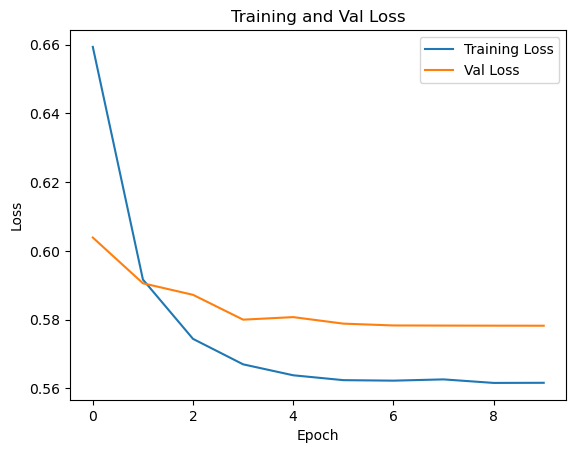

In [55]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Val Loss")
plt.legend()
plt.show()

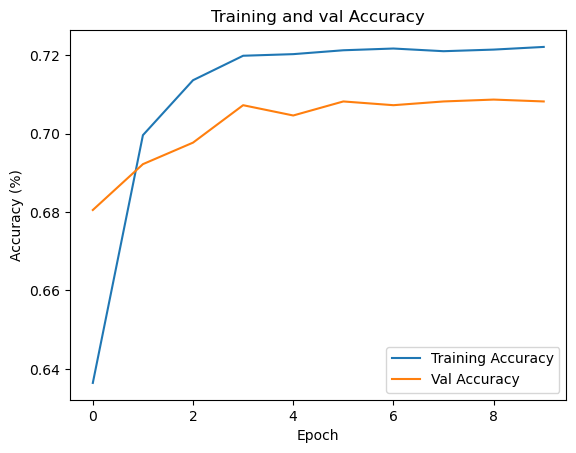

In [56]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and val Accuracy")
plt.legend()
plt.show()

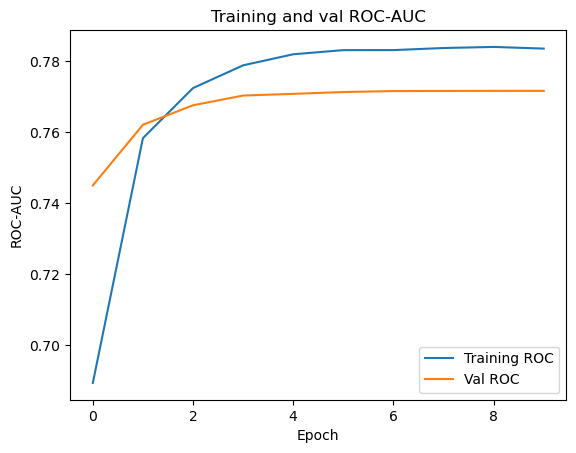

In [57]:
plt.plot(train_roc_aucs, label="Training ROC")
plt.plot(val_roc_aucs, label="Val ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Training and val ROC-AUC")
plt.legend()
plt.show()

In [60]:
correct_predictions_count = 0
all_preds = []
all_labels = []
y_true = []
y_scores = []

best_model =  CustomVGG12()
best_model.load_state_dict(torch.load("model_weights_Common_Task_2(2).pth"))
best_model.eval().to(device)

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        preds = (preds >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        y_true += labels.cpu().numpy().tolist()
        y_scores += outputs.cpu().numpy().tolist()
        correct_predictions_count += torch.sum(preds == labels).item()

total_instances = len(all_labels)
accuracy = correct_predictions_count / total_instances
roc_auc = roc_auc_score(y_true, y_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

100%|██████████| 66/66 [00:11<00:00,  5.58it/s]

Test Accuracy: 0.7199
ROC-AUC Score: 0.7796


In [ ]:
correct_predictions_count = 0
all_preds = []
all_labels = []
y_true = []
y_scores = []

best_model =  CustomVGG12()
best_model.load_state_dict(torch.load("model_weights_Common_Task_2(2).pth"))
best_model.eval().to(device)

best_modell = Custom_Net()
best_modell.load_state_dict(torch.load("model_weights_Common_Task_2(1).pth"))
best_modell.eval().to(device)

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        
        outputs_model1 = best_model(inputs)
        outputs_model2 = best_modell(inputs)

        preds_model1 = torch.sigmoid(outputs_model1)
        preds_model2 = outputs_model2
        
        preds = (preds_model1 + preds_model2) / 2
        preds = (preds >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        y_true += labels.cpu().numpy().tolist()
        y_scores += ((outputs_model1+outputs_model2)/2).cpu().numpy().tolist()
        correct_predictions_count += torch.sum(preds == labels).item()

total_instances = len(all_labels)
accuracy = correct_predictions_count / total_instances
roc_auc = roc_auc_score(y_true, y_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")